In [26]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
!wget https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

--2020-05-06 21:39:16--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 2606:4700:10::6816:4b8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4496459151 (4.2G) [application/octet-stream]
Saving to: ‘cc.ru.300.bin.gz’

cc.ru.300.bin.gz    100%[===================>]   4.19G  22.3MB/s    in 3m 13s  

2020-05-06 21:42:30 (22.2 MB/s) - ‘cc.ru.300.bin.gz’ saved [4496459151/4496459151]

--2020-05-06 21:42:31--  https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/43l702z5a5i2w8j/gazeta_train.txt [following]
--2020-05-06 21:42:3

In [0]:
!gzip -d cc.ru.300.bin.gz

In [3]:
!pip install --upgrade razdel allennlp torch fasttext OpenNMT-py networkx pymorphy2 nltk rouge==0.3.1 summa sentencepiece==0.1.8

     |████████████████████████████████| 7.6MB 4.3MB/s 
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 194kB 42.3MB/s 
Requirement already up-to-date: networkx in /usr/local/lib/python3.6/dist-packages (2.4)
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 1.4MB 45.2MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 1.0MB 49.0MB/s 
     |████████████████████████████████| 133kB 52.0MB/s 
     |████████████████████████████████| 204kB 55.1MB/s 
     |████████████████████████████████| 256kB 48.9MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 245kB 50.8MB/s 
     |████████████████████████████████| 163kB 49.7MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 5.2M

In [0]:
%matplotlib inline

## EDA

Посмотрим на то, как устроен датасет

In [5]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [0]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [0]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [8]:
print(min([record["date"] for record in train_records]))
print(max([record["date"] for record in train_records]))
print(min([record["date"] for record in val_records]))
print(max([record["date"] for record in val_records]))
print(min([record["date"] for record in test_records]))
print(max([record["date"] for record in test_records]))

2010-06-01 10:35:49
2019-05-31 23:56:26
2019-06-01 08:30:00
2019-09-30 23:11:23
2019-10-01 08:23:02
2020-03-23 22:16:23


Посчитаем статистику по словам

In [0]:
from collections import Counter, namedtuple
import razdel
import pymorphy2

Stats = namedtuple("Stats", "vocabulary,lemma_vocabulary,words_counts,unique_words_counts")

def collect_stats(records, lower=True, text_max_words=3000, summary_max_words=100, nrows=1000):
    morph = pymorphy2.MorphAnalyzer()
    
    text_stats = Stats(Counter(),  Counter(), list(), list())
    summary_stats = Stats(Counter(),  Counter(), list(), list())

    def update_record_field_stats(field, stats, max_words):
        words = [word.text for word in razdel.tokenize(field)][:max_words]
        lemmas = [morph.parse(word)[0].normal_form for word in words]
        stats.vocabulary.update(words)
        stats.lemma_vocabulary.update(lemmas)
        stats.words_counts.append(len(words))
        stats.unique_words_counts.append(len(set(words)))

    for i, record in enumerate(records):
        if i >= nrows:
            break
        text = record["text"]
        text = text if not lower else text.lower()
        update_record_field_stats(text, text_stats, text_max_words)

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        summary_words = [word.text for word in razdel.tokenize(summary)]
        update_record_field_stats(summary, summary_stats, summary_max_words)
    return text_stats, summary_stats

In [10]:
test_text_stats, test_summary_stats = collect_stats(test_records)
print("Test texts vocabulary size: ", len(test_text_stats.vocabulary))
print("Test texts lemma vocabulary size: ", len(test_text_stats.lemma_vocabulary))
print("Test summaries vocabulary size: ", len(test_summary_stats.vocabulary))
print("Test summaries lemma vocabulary size: ", len(test_summary_stats.lemma_vocabulary))
print("Test common lemmas summary vs text: ", len(set(test_text_stats.lemma_vocabulary.keys()) & set(test_summary_stats.lemma_vocabulary.keys())))

Test texts vocabulary size:  73282
Test texts lemma vocabulary size:  32752
Test summaries vocabulary size:  15196
Test summaries lemma vocabulary size:  8673
Test common lemmas summary vs text:  8408


In [11]:
test_text_stats.lemma_vocabulary.most_common(100)

[(',', 54104),
 ('.', 38406),
 ('в', 28069),
 ('и', 14555),
 ('«', 12789),
 ('»', 12716),
 ('на', 11741),
 ('что', 9225),
 ('—', 8528),
 ('с', 8173),
 ('не', 7279),
 ('по', 6354),
 ('быть', 6232),
 ('он', 6206),
 ('это', 5730),
 ('год', 4998),
 ('который', 3920),
 ('о', 3888),
 ('тот', 3200),
 ('как', 2981),
 ('из', 2868),
 ('к', 2828),
 ('россия', 2713),
 ('она', 2659),
 ('они', 2632),
 ('а', 2597),
 ('свой', 2542),
 ('для', 2473),
 ('за', 2402),
 ('весь', 2327),
 ('один', 2131),
 ('также', 2105),
 ('от', 2061),
 ('этот', 1919),
 ('я', 1865),
 ('мочь', 1855),
 ('мы', 1755),
 ('у', 1725),
 ('но', 1699),
 ('страна', 1657),
 ('российский', 1589),
 ('(', 1583),
 (')', 1583),
 ('человек', 1583),
 ('президент', 1582),
 ('сша', 1578),
 ('при', 1564),
 ('до', 1523),
 ('после', 1506),
 ('время', 1500),
 ('слово', 1409),
 ('украина', 1405),
 ('заявить', 1374),
 ('стать', 1368),
 ('так', 1351),
 ('такой', 1307),
 (':', 1265),
 ('%', 1249),
 ('то', 1230),
 ('уже', 1172),
 ('однако', 1100),
 ('два

(array([  8.,  15.,  38.,  94., 236., 224., 138.,  65.,  25.,  26.,  25.,
         21.,  14.,  14.,  14.,   6.,  12.,   8.,   6.,  11.]),
 array([ 408. ,  462.5,  517. ,  571.5,  626. ,  680.5,  735. ,  789.5,
         844. ,  898.5,  953. , 1007.5, 1062. , 1116.5, 1171. , 1225.5,
        1280. , 1334.5, 1389. , 1443.5, 1498. ]),
 <a list of 20 Patch objects>)

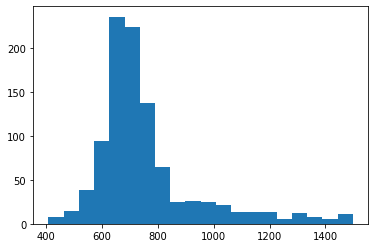

In [12]:
import matplotlib.pyplot as plt

plt.hist(test_text_stats.words_counts, 20)

(array([  6.,   8.,  34., 103., 291., 233., 121.,  49.,  30.,  33.,  17.,
         14.,  23.,  10.,   8.,   9.,   6.,   2.,   2.,   1.]),
 array([229. , 260.7, 292.4, 324.1, 355.8, 387.5, 419.2, 450.9, 482.6,
        514.3, 546. , 577.7, 609.4, 641.1, 672.8, 704.5, 736.2, 767.9,
        799.6, 831.3, 863. ]),
 <a list of 20 Patch objects>)

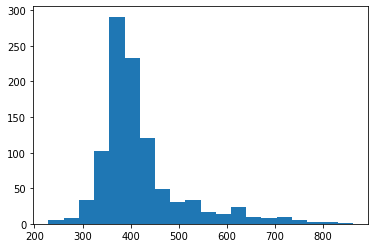

In [13]:
import matplotlib.pyplot as plt

plt.hist(test_text_stats.unique_words_counts, 20)

(array([  3.,   5.,  20.,  23.,  32.,  53.,  64.,  82., 126.,  91.,  79.,
         89.,  91.,  64.,  63.,  38.,  38.,  15.,  15.,   9.]),
 array([20.  , 23.25, 26.5 , 29.75, 33.  , 36.25, 39.5 , 42.75, 46.  ,
        49.25, 52.5 , 55.75, 59.  , 62.25, 65.5 , 68.75, 72.  , 75.25,
        78.5 , 81.75, 85.  ]),
 <a list of 20 Patch objects>)

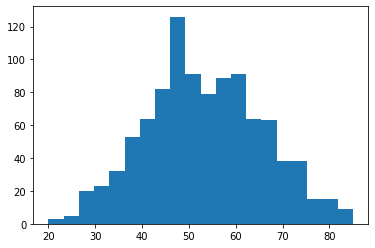

In [14]:
import matplotlib.pyplot as plt

plt.hist(test_summary_stats.words_counts, 20)

In [15]:
train_text_stats, train_summary_stats = collect_stats(train_records)
print("Train texts vocabulary size: ", len(train_text_stats.vocabulary))
print("Train texts lemma vocabulary size: ", len(train_text_stats.lemma_vocabulary))
print("Train summaries vocabulary size: ", len(train_summary_stats.vocabulary))
print("Train summaries lemma vocabulary size: ", len(train_summary_stats.lemma_vocabulary))
print("Train common lemmas summary vs text: ", len(set(train_text_stats.lemma_vocabulary.keys()) & set(train_summary_stats.lemma_vocabulary.keys())))

Train texts vocabulary size:  82978
Train texts lemma vocabulary size:  38089
Train summaries vocabulary size:  15441
Train summaries lemma vocabulary size:  9087
Train common lemmas summary vs text:  8703


In [16]:
print("Text common lemmas train vs test: ", len(set(train_text_stats.lemma_vocabulary.keys()) & set(test_text_stats.lemma_vocabulary.keys())))
print("Summary common lemmas train vs test: ", len(set(train_summary_stats.lemma_vocabulary.keys()) & set(test_summary_stats.lemma_vocabulary.keys())))

Text common lemmas train vs test:  18875
Summary common lemmas train vs test:  4508


(array([  1.,   1.,   2.,  17.,  59.,  76., 112., 179., 144., 108.,  82.,
         53.,  43.,  34.,  31.,  24.,  14.,   6.,   5.,   9.]),
 array([ 167.  ,  233.25,  299.5 ,  365.75,  432.  ,  498.25,  564.5 ,
         630.75,  697.  ,  763.25,  829.5 ,  895.75,  962.  , 1028.25,
        1094.5 , 1160.75, 1227.  , 1293.25, 1359.5 , 1425.75, 1492.  ]),
 <a list of 20 Patch objects>)

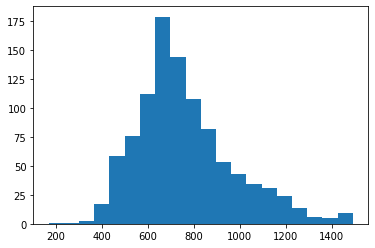

In [17]:
import matplotlib.pyplot as plt

plt.hist(train_text_stats.words_counts, 20)

## Lead-3

Первый baseline - первые 3 предложения текста в качестве summary.


В качестве метрик здесь и далее используем BLEU и ROUGE.

In [0]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

In [19]:
import razdel

def calc_lead_n_score(records, n=3, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        sentences = [sentence.text for sentence in razdel.sentenize(text)]
        prediction = " ".join(sentences[:n])
        predictions.append(prediction)

    calc_scores(references, predictions)

calc_lead_n_score(test_records, n=1)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области.
BLEU:  0.19177311186434495
ROUGE:  {'rouge-1': {'f': 0.23804097238957525, 'p': 0.22208274285774904, 'r': 0.37762764047433917}, 'rouge-2': {'f': 0.10027796832321115, 'p': 0.09647636782929753, 'r': 0.15833772153385062}, 'rouge-l': {'f': 0.1835646488408507, 'p': 0.2022959168891477, 'r': 0.34937017731940756}}


##TextRank

TextRank - unsupervised метод для составления кратких выжимок из текста. 

### Самописный TextRank

In [0]:
from itertools import combinations
import networkx as nx
import pymorphy2
import numpy as np

def unique_words_similarity(words1, words2):
    '''
    Функция подсчёта близости предложений на основе пересечения слов
    ''' 
    words1 = set(words1)
    words2 = set(words2)
    if not len(words1) or not len(words2):
        return 0.0
    return len(words1.intersection(words2))/(np.log10(len(words1)) + np.log10(len(words2)))

def gen_text_rank_summary(text, calc_similarity=unique_words_similarity, summary_part=0.1, lower=True, morph=None):
    '''
    Составление summary с помощью TextRank
    '''
    # Разбиваем текст на предложения
    sentences = [sentence.text for sentence in razdel.sentenize(text)]
    n_sentences = len(sentences)

    # Токенизируем предложения
    sentences_words = [[token.text.lower() if lower else token.text for token in razdel.tokenize(sentence)] for sentence in sentences]

    # При необходимости лемматизируем слова
    if morph is not None:
        sentences_words = [[morph.parse(word)[0].normal_form for word in words] for words in sentences_words]

    # Для каждой пары предложений считаем близость
    pairs = combinations(range(n_sentences), 2)
    scores = [(i, j, calc_similarity(sentences_words[i], sentences_words[j])) for i, j in pairs]

    # Строим граф с рёбрами, равными близости между предложениями
    g = nx.Graph()
    g.add_weighted_edges_from(scores)

    # Считаем PageRank
    pr = nx.pagerank(g)
    result = [(i, pr[i], s) for i, s in enumerate(sentences) if i in pr]
    result.sort(key=lambda x: x[1], reverse=True)

    # Выбираем топ предложений
    n_summary_sentences = max(int(n_sentences * summary_part), 1)
    result = result[:n_summary_sentences]

    # Восстанавливаем оригинальный их порядок
    result.sort(key=lambda x: x[0])

    # Восстанавливаем текст выжимки
    predicted_summary = " ".join([sentence for i, proba, sentence in result])
    predicted_summary = predicted_summary.lower() if lower else predicted_summary
    return predicted_summary

def calc_text_rank_score(records, calc_similarity=unique_words_similarity, summary_part=0.1, lower=True, nrows=1000, morph=None):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary = gen_text_rank_summary(text, calc_similarity, summary_part, lower, morph=morph)
        text = text if not lower else text.lower()
        predictions.append(predicted_summary)

    calc_scores(references, predictions)

morph = pymorphy2.MorphAnalyzer()
# calc_text_rank_score(test_records)
# calc_text_rank_score(test_records, morph=morph)

### **Задание 1**

Сделайте TextRank с другой мерой близости предложений: по FastText, ELMo или BERT эмбеддингам

In [0]:
from gensim.models import FastText
from scipy.linalg import norm

fasttext_model = FastText.load_fasttext_format("cc.ru.300.bin")

In [37]:
'огп' in fasttext_model.wv

False

In [38]:
def fasttext_similarity(words1, words2):
    def get_seq_vector(words):
        vectors = []
        for word in words:
            if word in fasttext_model.wv:
                vectors.append(fasttext_model.wv[word])
        return np.mean(vectors, axis=0)

    u = get_seq_vector(words1)
    v = get_seq_vector(words2)

    return np.dot(u, v) / (norm(u) * norm(v))

calc_text_rank_score(test_records, calc_similarity=fasttext_similarity, morph=morph)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: проживи месяц в ниловой пустыни, выполняя послушания, и найди ответы на вопросы, которые давно беспокоят», — так анонсирует телеканал свой проект. церковь призывает молиться об усопших, а не делать хайп на их смерти», — указал он. «если человеку невоцерковленному, далекому от церкви, в двух словах сказать, для чего нужна церковь — церковь… нужна для того, чтобы был силен дух нашего народа», — говорил предстоятель. по его словам, такая зависимость сродни алкогольной или наркотической — электронные устройства лишают человека свободы и приводят к «дегуманизации» личности, уводя в виртуальную реальность.
BLEU:  0.2683074

In [0]:
config = {
  "chainer": {
    "in": ["texts"],
    "pipe": [
      {
        "class_name": "transformers_bert_preprocessor",
        "vocab_file": "{BERT_PATH}/vocab.txt",
        "do_lower_case": false,
        "max_seq_length": 512,
        "in": ["texts"],
        "out": ["tokens", "subword_tokens", "subword_tok_ids", "startofword_markers", "attention_mask"]
      },
      {
        "class_name": "transformers_bert_embedder",
        "bert_config_path": "{BERT_PATH}/bert_config.json",
        "load_path": "{BERT_PATH}",
        "truncate": true,
        "in": ["subword_tok_ids", "startofword_markers", "attention_mask"],
        "out": ["word_emb", "subword_emb", "max_emb", "mean_emb", "pooler_output"]
      }
    ],
    "out": ["tokens", "word_emb", "subword_tokens", "subword_emb", "max_emb", "mean_emb", "pooler_output"]
  },
  "train": {},
  "metadata": {
    "variables": {
      "ROOT_PATH": "~/.deeppavlov",
      "DOWNLOADS_PATH": "{ROOT_PATH}/downloads",
      "BERT_PATH": "{DOWNLOADS_PATH}/bert_models/multi_cased_L-12_H-768_A-12_pt"
    },
    "requirements": [
      "{DEEPPAVLOV_PATH}/requirements/transformers.txt",
      "{DEEPPAVLOV_PATH}/requirements/pytorch.txt"
    ],
    "labels": {},
    "download": [
      {
        "url": "http://files.deeppavlov.ai/deeppavlov_data/bert/multi_cased_L-12_H-768_A-12_pt.tar.gz",
        "subdir": "{DOWNLOADS_PATH}/bert_models"
      }
    ]
  }
}

### Summa

In [0]:
from summa.summarizer import summarize

def calc_summa_score(records, summary_part=0.1, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        predicted_summary = summarize(text, ratio=summary_part, language='russian').replace("\n", " ")
        predictions.append(predicted_summary)

    calc_scores(references, predictions)

calc_summa_score(test_records)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: проживи месяц в ниловой пустыни, выполняя послушания, и найди ответы на вопросы, которые давно беспокоят», — так анонсирует телеканал свой проект. «у нас же даже многие журналисты не знают и не понимают многого, связанного с религиозными ценностями, а здесь — попытка обратить их внимание на это, может быть, им будет интересно. стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека. и это что — жизнь, что ли?
BLEU:  0.2762958192799957
ROUGE:  {'rouge-1': {'f': 0.1770425497877709, 'p': 0.14391909693539454, 'r': 0.247378763312854

## Oracle summary

Для сведения задачи к extractive summarization мы должны выбрать те предложения из оригинального текста, которые наиболее похожи на наше целевое summary по нашим метрикам.

In [0]:
import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

In [0]:
def calc_oracle_score(records, nrows=1000, lower=True):
    references = []
    predictions = []
    rouge = Rouge()
  
    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, _ = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge))
        predictions.append(predicted_summary)

    calc_scores(references, predictions)


calc_oracle_score(test_records)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области. в комментарии также отмечается, что это беспрецедентный подобный проект на телевидении. стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
BLEU:  0.531336150784986
ROUGE:  {'rouge-1': {'f': 0.36951810858804146, 'p': 0.4053281117404892, 'r': 0.3661389123393327}, 'rouge-2': {'f': 0.2087846693590

## Extractive RNN

Теперь пробуем предсказать oracle summary

### BPE
Для начала сделаем BPE токенизацию

In [0]:
import os

from sentencepiece import SentencePieceTrainer

def train_bpe(records, model_path, model_type="bpe", vocab_size=15000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for record in train_records:
            summary = record["summary"].strip()
            text = record["text"].strip()
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    cmd = "--input={} --model_prefix={} --vocab_size={} --model_type={}".format(
        temp_file_name,
        os.path.join(model_path, model_type),
        vocab_size,
        model_type)
    SentencePieceTrainer.Train(cmd)

!rm -f bpe.model
!rm -f bpe.vocab
train_bpe(train_records, "./")

In [0]:
!head bpe.vocab
!cat bpe.vocab | wc -l

<unk>	0
<s>	0
</s>	0
▁п	-0
▁с	-1
▁в	-2
ро	-3
ст	-4
ра	-5
на	-6
15000


In [0]:
from sentencepiece import SentencePieceProcessor

bpe_processor = SentencePieceProcessor()
bpe_processor.Load("bpe.model")

def bpe_tokenize(text, bpe_processor):
    return bpe_processor.EncodeAsPieces(text)

bpe_tokenize("октябрь богат на изменения", bpe_processor)

['▁октябрь', '▁бога', 'т', '▁на', '▁изменения']

### Словарь
Составим словарь для индексации токенов

In [0]:
from collections import Counter
from typing import List, Tuple
import os

class Vocabulary:
    def __init__(self):
        self.index2word = list()
        self.word2index = dict()
        self.word2count = Counter()
        self.reset()

    def get_pad(self):
        return self.word2index["<pad>"]

    def get_sos(self):
        return self.word2index["<sos>"]

    def get_eos(self):
        return self.word2index["<eos>"]

    def get_unk(self):
        return self.word2index["<unk>"]

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = len(self.index2word)
            self.word2count[word] += 1
            self.index2word.append(word)
        else:
            self.word2count[word] += 1
    
    def has_word(self, word) -> bool:
        return word in self.word2index

    def get_index(self, word):
        if word in self.word2index:
            return self.word2index[word]
        return self.get_unk()

    def get_word(self, index):
        return self.index2word[index]

    def size(self):
        return len(self.index2word)

    def is_empty(self):
        empty_size = 4
        return self.size() <= empty_size

    def shrink(self, n):
        best_words = self.word2count.most_common(n)
        self.reset()
        for word, count in best_words:
            self.add_word(word)
            self.word2count[word] = count

    def reset(self):
        self.word2count = Counter()
        self.index2word = ["<pad>", "<sos>", "<eos>", "<unk>"]
        self.word2index = {word: index for index, word in enumerate(self.index2word)}

In [0]:
def build_vocabulary(records, bpe_processor, lower=True): 
    vocabulary = Vocabulary()
    for record in records:
        text = record["text"]
        text = text.lower() if lower else text
        tokens = bpe_tokenize(text, bpe_processor)
        for token in tokens:
            vocabulary.add_word(token)
    return vocabulary

vocabulary = build_vocabulary(train_records, bpe_processor)
print(vocabulary.word2count.most_common(100)) 

[(',', 2467870), ('.', 1770601), ('▁в', 1432966), ('▁и', 856627), ('▁«', 769136), ('▁на', 667157), ('▁не', 458901), ('▁—', 423218), ('▁с', 407759), ('▁что', 399348), ('▁по', 355321), ('»', 349402), ('-', 299470), ('»,', 239006), ('▁за', 198471), ('▁а', 198254), ('▁из', 182499), ('».', 172453), ('▁о', 164747), ('▁к', 163134), ('▁у', 146741), ('▁от', 143396), ('▁но', 141837), ('▁как', 135981), ('ли', 128134), ('л', 124445), ('▁он', 124281), ('▁до', 124190), ('▁это', 116988), ('▁для', 116766), ('▁(', 116117), ('▁его', 110776), ('ла', 108900), ('но', 106047), ('м', 105072), ('▁при', 103694), ('на', 100694), ('ка', 94019), ('▁года', 92684), ('т', 92201), (':', 92057), ('в', 90927), ('с', 90879), ('ной', 87275), ('▁,', 86516), ('▁также', 83781), ('▁все', 82822), ('▁после', 79961), ('▁россии', 79895), ('ми', 79323), ('▁–', 79219), ('та', 77078), ('▁то', 76579), ('ть', 75498), ('▁', 75010), ('ных', 74458), ('▁со', 74384), ('х', 74290), ('к', 73601), ('я', 72829), ('е', 71302), ('ло', 70528), (

### Кэш oracle summary
Закэшируем oracle summary, чтобы не пересчитывать их каждый раз

In [0]:
from rouge import Rouge
import razdel

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in enumerate(records):
        if i >= nrows:
            break
        if i % 128 == 0:
            print(i)
        text = record["text"]
        summary = record["summary"]
        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary
    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=16384)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=1024)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=1024)

0
128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3072
3200
3328
3456
3584
3712
3840
3968
4096
4224
4352
4480
4608
4736
4864
4992
5120
5248
5376
5504
5632
5760
5888
6016
6144
6272
6400
6528
6656
6784
6912
7040
7168
7296
7424
7552
7680
7808
7936
8064
8192
8320
8448
8576
8704
8832
8960
9088
9216
9344
9472
9600
9728
9856
9984
10112
10240
10368
10496
10624
10752
10880
11008
11136
11264
11392
11520
11648
11776
11904
12032
12160
12288
12416
12544
12672
12800
12928
13056
13184
13312
13440
13568
13696
13824
13952
14080
14208
14336
14464
14592
14720
14848
14976
15104
15232
15360
15488
15616
15744
15872
16000
16128
16256
0
128
256
384
512
640
768
896
0
128
256
384
512
640
768
896


In [0]:
import json

def write_gazeta_records(records, file_name):
    with open(file_name, "w") as w:
        for record in records:
            record["oracle_sentences"] = list(record["oracle_sentences"])
            w.write(json.dumps(record, ensure_ascii=False).strip() + "\n")

write_gazeta_records(ext_train_records, "gazeta_train_with_oracle.txt")
write_gazeta_records(ext_val_records, "gazeta_val_with_oracle.txt")
write_gazeta_records(ext_test_records, "gazeta_test_with_oracle.txt")

In [0]:
!cp "gazeta_train_with_oracle.txt" "drive/My Drive/gazeta_train_with_oracle.txt"
!cp "gazeta_val_with_oracle.txt" "drive/My Drive/gazeta_val_with_oracle.txt"
!cp "gazeta_test_with_oracle.txt" "drive/My Drive/gazeta_test_with_oracle.txt"

In [0]:
!cp "drive/My Drive/gazeta_train_with_oracle.txt" "gazeta_train_with_oracle.txt"
!cp "drive/My Drive/gazeta_val_with_oracle.txt" "gazeta_val_with_oracle.txt"
!cp "drive/My Drive/gazeta_test_with_oracle.txt" "gazeta_test_with_oracle.txt"

In [0]:
ext_train_records = read_gazeta_records("gazeta_train_with_oracle.txt")
ext_val_records = read_gazeta_records("gazeta_val_with_oracle.txt")
ext_test_records = read_gazeta_records("gazeta_test_with_oracle.txt")

### Составление батчей

In [0]:
import random
import math
import razdel
import torch
import numpy as np
from rouge import Rouge


class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True, lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]
            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []
            for data_ind in batch_indices:
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)

                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences)[1]
                else:
                    sentences_indicies = record["oracle_sentences"]

                inputs = [list(map(self.vocabulary.get_index, bpe_tokenize(sentence, self.bpe_processor)[:self.max_sentence_length])) for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)
            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device)
            tensor_outputs = torch.zeros((self.batch_size, max_sentences), dtype=torch.float32, device=self.device)
            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.LongTensor(sentence_tokens)
            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [0]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 4, bpe_processor)

In [0]:
for batch in train_iterator:
    print(batch)
    break

{'inputs': tensor([[[   54,   892, 11342,  ...,     0,     0,     0],
         [   72,   937,   592,  ...,     0,     0,     0],
         [ 1042,   292,    18,  ...,     0,     0,     0],
         ...,
         [  454,    26,   558,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0]],

        [[ 4107, 12488,   265,  ...,     0,     0,     0],
         [    4,   522,   326,  ...,     0,     0,     0],
         [   22,    54,     6,  ...,    27,  6973,    25],
         ...,
         [  222,   185,   186,  ...,     0,     0,     0],
         [   22,    19,  2496,  ...,     0,     0,     0],
         [   22,  1929,    18,  ...,     0,     0,     0]],

        [[   19,  3275,    19,  ...,     0,     0,     0],
         [ 6569,  5153,   137,  ...,     0,     0,     0],
         [   19, 13993,  5400,  ...,     0,     0,     0],
         ...,
         [ 1181,  1871,  8825,  ...,     0,     0,     0],

### Обучение

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

def train_model(model, train_records, val_records, vocabulary, bpe_processor, batch_size=32,
                epochs_count=10, loss_every_nsteps=16, lr=0.001, device_name="cuda"):
    params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params: {}".format(params_count))
    device = torch.device(device_name)
    model = model.to(device)
    total_loss = 0
    start_time = time.time()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.BCEWithLogitsLoss().to(device)
    for epoch in range(epochs_count):
        for step, batch in enumerate(BatchIterator(train_records, vocabulary, batch_size, bpe_processor, device=device)):
            model.train()
            logits = model(batch["inputs"]) # Прямой проход
            loss = loss_function(logits, batch["outputs"]) # Подсчёт ошибки
            loss.backward() # Подсчёт градиентов dL/dw
            optimizer.step() # Градиентный спуск или его модификации (в данном случае Adam)
            optimizer.zero_grad() # Зануление градиентов, чтобы их спокойно менять на следующей итерации
            total_loss += loss.item()
            if step % loss_every_nsteps == 0 and step != 0:
                val_total_loss = 0
                val_batch_count = 0
                model.eval()
                for _, val_batch in enumerate(BatchIterator(val_records, vocabulary, batch_size, bpe_processor, device=device)):
                    logits = model(val_batch["inputs"]) # Прямой проход
                    val_total_loss += loss_function(logits, batch["outputs"]) # Подсчёт ошибки
                    val_batch_count += 1
                avg_val_loss = val_total_loss/val_batch_count
                print("Epoch = {}, Avg Train Loss = {:.4f}, Avg val loss = {:.4f}, Time = {:.2f}s".format(epoch, total_loss / loss_every_nsteps, avg_val_loss, time.time() - start_time))
                total_loss = 0
                start_time = time.time()
        total_loss = 0
        start_time = time.time()

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super(SentenceEncoderRNN, self).__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.embedding_layer(inputs)
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 token_embedding_dim=256,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=1,
                 dropout=0.3):
        super(SentenceTaggerRNN, self).__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.tanh_layer = nn.Tanh()

    def forward(self, inputs, hidden=None):
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = embedded_sentences.reshape(batch_size, sentences_count, -1)
        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        outputs = self.dropout_layer(outputs)
        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        content = self.content_linear_layer(outputs).squeeze(2)
        salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2)
        return content + salience

model = SentenceTaggerRNN(vocabulary.size())
train_model(model, ext_train_records, ext_val_records, vocabulary, bpe_processor, device_name="cuda", batch_size=32)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Trainable params: 5250305
Epoch = 0, Avg Train Loss = 0.3309, Avg val loss = 0.2649, Time = 6.50s
Epoch = 0, Avg Train Loss = 0.2509, Avg val loss = 0.2661, Time = 6.25s
Epoch = 0, Avg Train Loss = 0.2351, Avg val loss = 0.2393, Time = 6.19s
Epoch = 0, Avg Train Loss = 0.2416, Avg val loss = 0.2256, Time = 6.17s
Epoch = 0, Avg Train Loss = 0.2331, Avg val loss = 0.2530, Time = 6.16s
Epoch = 0, Avg Train Loss = 0.2335, Avg val loss = 0.2323, Time = 6.22s
Epoch = 0, Avg Train Loss = 0.2426, Avg val loss = 0.2350, Time = 6.15s
Epoch = 0, Avg Train Loss = 0.2270, Avg val loss = 0.2374, Time = 6.20s
Epoch = 0, Avg Train Loss = 0.2299, Avg val loss = 0.2378, Time = 6.15s
Epoch = 0, Avg Train Loss = 0.2345, Avg val loss = 0.2711, Time = 6.15s
Epoch = 0, Avg Train Loss = 0.2309, Avg val loss = 0.2176, Time = 6.26s
Epoch = 0, Avg Train Loss = 0.2332, Avg val loss = 0.2271, Time = 6.13s
Epoch = 0, Avg Train Loss = 0.2252, Avg val loss = 0.2660, Time = 6.25s
Epoch = 0, Avg Train Loss = 0.2348, Av

KeyboardInterrupt: ignored

In [0]:
device = torch.device("cuda")

references = []
predictions = []
for step, batch in enumerate(BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)):
    logits = model(batch["inputs"]) # Прямой проход
    records = batch["records"]
    for record, record_logits in zip(records, logits):
        sentences = record["sentences"]
        predicted_summary = []
        for i, logit in enumerate(record_logits):
            if logit > 0.0:
                predicted_summary.append(sentences[i])
        if not predicted_summary:
            predicted_summary.append(sentences[torch.max(record_logits, dim=0)[1].item()])
        predicted_summary = " ".join(predicted_summary)
        references.append(record["summary"].lower())
        predictions.append(predicted_summary)

calc_scores(references, predictions)

Count: 1024
Ref: восемь коротких рабочих недель ожидают россиян в 2020 году, подсчитал роструд. сразу после новогодних праздников первая трудовая неделя продлится всего два дня. власти не исключают в будущем переход страны на четырехдневную рабочую неделю. при условии высокой производительности труда.
Hyp: при этом следующая майская неделя также будет сокращенной из-за выходных, приуроченных ко дню победы, добавил шкловец.
BLEU:  0.20492005731883856
ROUGE:  {'rouge-1': {'f': 0.20670073721820156, 'p': 0.3228627140233606, 'r': 0.163967760477759}, 'rouge-2': {'f': 0.08791812710854992, 'p': 0.13957926101621407, 'r': 0.07001153329401598}, 'rouge-l': {'f': 0.1564746913621876, 'p': 0.2906696446477151, 'r': 0.14713786844300072}}


### **Задание 2**
Доделайте модель в соответствии с https://arxiv.org/pdf/1611.04230.pdf